# MNIST by pytorch

almost the same as https://github.com/pytorch/examples/blob/master/mnist/main.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
import os, sys, shutil, glob, re, time, argparse
%matplotlib inline

torch.set_printoptions(sci_mode = False)

In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:3000px;  
}

In [3]:
parser = argparse.ArgumentParser(prog = 'mnist', description = 'mnist by PyTorch')
parser.add_argument('--batch-size', type = int, default = 64, metavar = 'N', help = 'training batch size (default: 64)')
parser.add_argument('--test-batch-size', type = int, default = 1000, metavar = 'N', help = 'testing batch size (default: 1000)')
parser.add_argument('--epochs', type=int, default = 10, metavar = 'N', help = 'number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default = 0.01, metavar = 'LR', help = 'learning rate (default: 0.01)')
parser.add_argument('--momentum', type = float, default = 0.5, metavar = 'M', help = 'SGD momentum (default: 0.5)')
parser.add_argument('--no-gpu', action = 'store_true', help = 'not use GPU (cuda)')
parser.add_argument('--seed', type = int, default = 1, metavar = 'S', help='random seed (default: 1)')
parser.add_argument('--log-times', type = int, default = 10, metavar = 'N', help='number of times to log training status per epoch (default: 10)')
parser.print_help()

usage: mnist [-h] [--batch-size N] [--test-batch-size N] [--epochs N]
             [--lr LR] [--momentum M] [--no-gpu] [--seed S] [--log-times N]

mnist by PyTorch

optional arguments:
  -h, --help           show this help message and exit
  --batch-size N       training batch size (default: 64)
  --test-batch-size N  testing batch size (default: 1000)
  --epochs N           number of epochs to train (default: 10)
  --lr LR              learning rate (default: 0.01)
  --momentum M         SGD momentum (default: 0.5)
  --no-gpu             not use GPU (cuda)
  --seed S             random seed (default: 1)
  --log-times N        number of times to log training status per epoch
                       (default: 10)


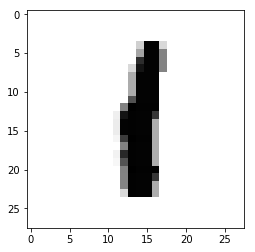

In [4]:
train_data = torch.load('/media/computer/work/data/MNIST/processed/training.pt')
test_data = torch.load('/media/computer/work/data/MNIST/processed/test.pt')

train_data = (train_data[0].view(train_data[0].shape[0], -1, train_data[0].shape[1], train_data[0].shape[2]).to(torch.float), train_data[1])
test_data  = (test_data[0].view(test_data[0].shape[0], -1, test_data[0].shape[1], test_data[0].shape[2]).to(torch.float), test_data[1])

plt.imshow(train_data[0][128][0].numpy(), cmap = "Greys");

In [7]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size = 5)
        self.fc1 = torch.nn.Linear(4*4*20, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        F = torch.nn.functional
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 4*4*20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train(model, device, train_loader, optimizer, scheduler, epoch, args):
    model.train()
    total_loss, total_correct = 0, 0
    log_batches = np.ceil(np.linspace(0, len(train_loader)-1, args.log_times))
    scheduler.step()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        scheduler.optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        scheduler.optimizer.step()
        correct = torch.sum(torch.argmax(outputs, dim = 1) == labels)
        total_loss += loss.item()
        total_correct += correct.item()
        if i in log_batches: print('Epoch {} [{}-{}/{}], average loss: {:.6f}, correct: {}/{} ({:.0f}%)'.format(epoch+1, len(inputs)*i+1, len(inputs)*(i+1), len(train_loader.dataset), loss.item(), correct.item(), len(inputs), correct.item()/len(inputs)*100))
    print('Summary of Epoch {}, average loss: {:.6f}, correct: {}/{} ({:.0f}%)\n'.format(epoch+1, total_loss/len(train_loader), total_correct, len(train_loader.dataset), total_correct/len(train_loader.dataset)*100))

def test(model, device, test_loader, args):
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += torch.nn.functional.cross_entropy(outputs, labels).item()
            correct += torch.sum(torch.argmax(outputs, dim = 1) == labels).item()
    print('\nTesting, average loss: {:.6f}, correct: {}/{} ({:.0f}%)\n'.format(loss/len(test_loader), correct, len(test_loader.dataset), correct/len(test_loader.dataset)*100))

In [8]:
args = parser.parse_args('--epochs 4 --lr 0.00001 --log-times 10'.split())
print(args)

np.random.seed(args.seed)
torch.manual_seed(args.seed)
device = torch.device('cuda' if not args.no_gpu and torch.cuda.is_available() else 'cpu')

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data[0], train_data[1]), args.batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data[0], test_data[1]), args.test_batch_size, num_workers = 4, pin_memory = True)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = args.lr, momentum = args.momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1000)



for i in range(args.epochs): 
    train(model, device, train_loader, optimizer, scheduler, i, args)
test(model, device, test_loader, args)

Namespace(batch_size=64, epochs=4, log_times=10, lr=1e-05, momentum=0.5, no_gpu=False, seed=1, test_batch_size=1000)
Epoch 1 [1-64/60000], average loss: 15.749887, correct: 10/64 (16%)
Epoch 1 [6721-6784/60000], average loss: 3.634071, correct: 10/64 (16%)
Epoch 1 [13377-13440/60000], average loss: 2.318348, correct: 20/64 (31%)
Epoch 1 [20033-20096/60000], average loss: 1.820209, correct: 31/64 (48%)
Epoch 1 [26689-26752/60000], average loss: 1.870949, correct: 29/64 (45%)
Epoch 1 [33345-33408/60000], average loss: 1.667532, correct: 33/64 (52%)
Epoch 1 [40001-40064/60000], average loss: 1.591776, correct: 33/64 (52%)
Epoch 1 [46657-46720/60000], average loss: 1.451933, correct: 34/64 (53%)
Epoch 1 [53313-53376/60000], average loss: 1.235796, correct: 38/64 (59%)
Epoch 1 [29985-30016/60000], average loss: 0.910317, correct: 21/32 (66%)
Summary of Epoch 1, average loss: 2.394273, correct: 24858/60000 (41%)

Epoch 2 [1-64/60000], average loss: 1.398572, correct: 34/64 (53%)
Epoch 2 [672